In [0]:
!tar -zxvf '/content/drive/My Drive/data/dl-bia/ax_t2_source_test.tar.gz'
print ("Uncompressing files")

Streaming output truncated to the last 5000 lines.
dl_bio/ax_t2_source_test/643231896274_7.npy
dl_bio/ax_t2_source_test/643231896274_8.npy
dl_bio/ax_t2_source_test/643231896274_9.npy
dl_bio/ax_t2_source_test/643372555523_1.npy
dl_bio/ax_t2_source_test/643372555523_2.npy
dl_bio/ax_t2_source_test/643372555523_3.npy
dl_bio/ax_t2_source_test/643372555523_4.npy
dl_bio/ax_t2_source_test/643372555523_5.npy
dl_bio/ax_t2_source_test/643372555523_6.npy
dl_bio/ax_t2_source_test/643372555523_7.npy
dl_bio/ax_t2_source_test/643372555523_8.npy
dl_bio/ax_t2_source_test/643372555523_9.npy
dl_bio/ax_t2_source_test/643470808788_1.npy
dl_bio/ax_t2_source_test/643470808788_2.npy
dl_bio/ax_t2_source_test/643470808788_3.npy
dl_bio/ax_t2_source_test/643470808788_4.npy
dl_bio/ax_t2_source_test/643470808788_5.npy
dl_bio/ax_t2_source_test/643470808788_6.npy
dl_bio/ax_t2_source_test/643470808788_7.npy
dl_bio/ax_t2_source_test/643470808788_8.npy
dl_bio/ax_t2_source_test/643470808788_9.npy
dl_bio/ax_t2_source_test/

In [1]:
import math
import torch
from torch import nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchvision.transforms import ToTensor

In [0]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.measure import compare_psnr, compare_ssim

In [0]:
PATH_TO_SOURCE_TEST = 'dl_bio/ax_t2_source_test'
RANDOM_STATE = 42

In [0]:
def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)

In [0]:
class SRGANMRIDataLoader(torch_data.Dataset):
    def __init__(self, path_to_data, scale, seed=None, imgs_names = None):
        super().__init__()

        if imgs_names:
            self.images = [os.path.join(path_to_data, file) for file in imgs_names if file.endswith('.npy')]
        else:
            self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) if file.endswith('.npy')]
        self.scale = scale
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        slice = npy_load(self.images[idx])
        slice_r = resize(slice[0], (320, 320), preserve_range=True)
        resized = self.sample_resize(slice)
        resized_new = np.dstack((resized,resized,resized))
        resized_tensor = ToTensor()(resized_new).unsqueeze(0)

        return self.images[idx], slice_r, resized_tensor
        
    def sample_resize(self, slice):
        slice_res = resize(slice[0], (320/self.scale, 320/self.scale), order = 1, preserve_range=True)
        #slice_res = resize(slice_res, (320, 320), order = 3, preserve_range=True)
        return slice_res

In [0]:
train_loader = SRGANMRIDataLoader(PATH_TO_SOURCE_TEST, seed=RANDOM_STATE, scale = 2)

In [0]:
resized_tensor = train_loader.__getitem__

In [0]:
len(train_loader)

14697

In [0]:
import torch
import torch.nn as nn
import math

class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output 

class _NetG(nn.Module):
    def __init__(self):
        super(_NetG, self).__init__()

        self.conv_input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.residual = self.make_layer(_Residual_Block, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)

        self.upscale4x = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            # nn.PixelShuffle(2),
            # nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale4x(out)
        out = self.conv_output(out)
        return out

In [0]:
torch.nn.Module.dump_patches = True

In [0]:
model = _NetG()

In [0]:
images = ['103330685055_1.npy', 
          '101014598432_3.npy',
          '101933419882_2.npy',
          '100807915589_3.npy',
          '100128575327_2.npy']

In [0]:
weights = torch.load('model_srresnet.pth')
model.load_state_dict(weights['model'].state_dict(), strict=False)
#main_model.load_state_dict(torch.load('model_srresnet.pth')['model'].state_dict())

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. Tried to save a patch, but couldn't create a writable file Conv2d.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. Saved a reverse patch to LeakyReLU.patch. Run `patch -p0 < LeakyReLU.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. Saved a reverse patch to Sequential.patch. Run `patch -p0 < Sequential.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serializat

_IncompatibleKeys(missing_keys=[], unexpected_keys=['residual.0.in1.running_mean', 'residual.0.in1.running_var', 'residual.0.in2.running_mean', 'residual.0.in2.running_var', 'residual.1.in1.running_mean', 'residual.1.in1.running_var', 'residual.1.in2.running_mean', 'residual.1.in2.running_var', 'residual.2.in1.running_mean', 'residual.2.in1.running_var', 'residual.2.in2.running_mean', 'residual.2.in2.running_var', 'residual.3.in1.running_mean', 'residual.3.in1.running_var', 'residual.3.in2.running_mean', 'residual.3.in2.running_var', 'residual.4.in1.running_mean', 'residual.4.in1.running_var', 'residual.4.in2.running_mean', 'residual.4.in2.running_var', 'residual.5.in1.running_mean', 'residual.5.in1.running_var', 'residual.5.in2.running_mean', 'residual.5.in2.running_var', 'residual.6.in1.running_mean', 'residual.6.in1.running_var', 'residual.6.in2.running_mean', 'residual.6.in2.running_var', 'residual.7.in1.running_mean', 'residual.7.in1.running_var', 'residual.7.in2.running_mean', 'r

In [0]:
input_tensor = []
slice_np = []
name, slice_r, res_tensor = train_loader.__getitem__(0)
print(slice_r.shape)
input_tensor.append(res_tensor)
slice_np.append(slice_r)
image_initial = np.array(slice_np)
image_initial = image_initial.squeeze(0)
print("Image_initial", image_initial.shape)
res_tensor = torch.as_tensor(res_tensor)
print(res_tensor.shape)


(320, 320)
Image_initial (320, 320)
torch.Size([1, 3, 160, 160])


In [0]:
model.eval()
out = model(res_tensor)

In [0]:
out.shape

torch.Size([1, 3, 640, 640])

(320, 320)


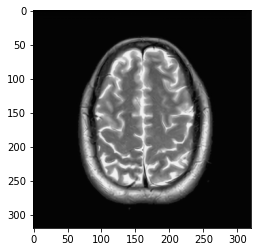

In [0]:
npimg = out[0].detach().numpy()
npimg = npimg[1, :, :]
npimg = resize(npimg, (320, 320), preserve_range=True)
print(npimg.shape)
# plt.figure(figsize = (12,13))
plt.imshow(npimg, cmap = "gray")
# plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [0]:
psnr = compare_psnr(image_initial, npimg)
ssim = compare_ssim(image_initial, npimg)
mae = abs(image_initial - npimg).mean()
print(psnr, ssim, mae)

33.19288815029749 0.9825129985719607 0.009912629


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [0]:
model.to('cuda')
model.eval()
path_to_sources = PATH_TO_SOURCE_TEST
psnr_list_4 = []
ssim_list_4 = []
mae_list_4 = []
for path, init_image, slice_sampled in tqdm(SRGANMRIDataLoader(path_to_sources, scale = 4, seed=RANDOM_STATE)):
    slice_sampled = slice_sampled.to('cuda')
    out = model(slice_sampled)
    npimg = out[0].cpu().detach().numpy()
    npimg = npimg[1, :, :]
    npimg = resize(npimg, (320, 320), preserve_range=True, order=3)
    psnr_list_4.append(compare_psnr(init_image, npimg))
    ssim_list_4.append(compare_ssim(init_image, npimg))
    mae_list_4.append(abs(init_image - npimg).mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [0]:
mae_mean_4 = np.array(mae_list_4).mean()
ssim_mean_4 = np.array(ssim_list_4).mean()
psnr_mean_4 = np.array(psnr_list_4).mean()
print("Mean absolute error on the test set", np.round(mae_mean_4, 4))
print("SSIM on the test set ",  np.round(ssim_mean_4, 4))
print("PSNR on the test set",  np.round(psnr_mean_4, 4))

Mean absolute error on the test set 0.022
SSIM on the test set  0.9301
PSNR on the test set 26.8763


In [0]:
print("For x4 upsampling:\n MAE mean = ", mae_mean_4, "\n PSNR mean = ", psnr_mean_4,
      "\n SSIM mean = ", ssim_mean_4)

For x4 upsampling:
 MAE mean =  0.022043185 
 PSNR mean =  26.87630973188978 
 SSIM mean =  0.9301058224965921


In [0]:
model.to('cuda')
model.eval()
path_to_sources = PATH_TO_SOURCE_TEST
psnr_list_2 = []
ssim_list_2 = []
mae_list_2 = []
for path, init_image, slice_sampled in tqdm(SRGANMRIDataLoader(path_to_sources, scale = 2, seed=RANDOM_STATE)):
    slice_sampled = slice_sampled.to('cuda')
    out = model(slice_sampled)
    npimg = out[0].cpu().detach().numpy()
    npimg = npimg[1, :, :]
    npimg = resize(npimg, (320, 320), preserve_range=True, order=3)
    psnr_list_2.append(compare_psnr(init_image, npimg))
    ssim_list_2.append(compare_ssim(init_image, npimg))
    mae_list_2.append(abs(init_image - npimg).mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [0]:
mae_mean_2 = np.array(mae_list_2).mean()
ssim_mean_2 = np.array(ssim_list_2).mean()
psnr_mean_2 = np.array(psnr_list_2).mean()
print("Mean absolute error on the test set", np.round(mae_mean_2, 4))
print("SSIM on the test set ",  np.round(ssim_mean_2, 4))
print("PSNR on the test set",  np.round(psnr_mean_2, 4))

Mean absolute error on the test set 0.0114
SSIM on the test set  0.9788
PSNR on the test set 32.6267


In [0]:
print("For x4 upsampling:\n MAE mean = ", mae_mean_2, "\n PSNR mean = ", psnr_mean_2,
      "\n SSIM mean = ", ssim_mean_2)

For x4 upsampling:
 MAE mean =  0.011383021 
 PSNR mean =  32.62674746935337 
 SSIM mean =  0.9788389495589879


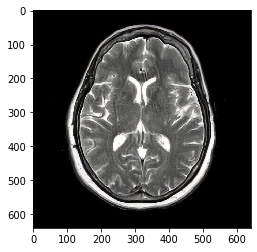

In [0]:
npimg_1 = out[0].detach().numpy()
# npimg = npimg[0, :, :]

image_3ch = np.transpose(npimg_1, (1, 2, 0))

plt.imshow(image_3ch)

In [0]:
model.to('cuda')
model.eval()
path_to_sources = PATH_TO_SOURCE_TEST
init_imgs = []
imgs_4 = []
imgs_4_diff = []
for path, init_image, slice_sampled in tqdm(SRGANMRIDataLoader(path_to_sources, scale = 4, seed=RANDOM_STATE, imgs_names=images)):
    slice_sampled = slice_sampled.to('cuda')
    out = model(slice_sampled)
    npimg = out[0].cpu().detach().numpy()
    npimg = npimg[1, :, :]
    npimg = resize(npimg, (320, 320), preserve_range=True, order=3)
    init_imgs.append(init_image)
    imgs_4.append(npimg)
    imgs_4_diff.append(init_image - npimg)

In [0]:
model.to('cuda')
model.eval()
path_to_sources = PATH_TO_SOURCE_TEST
init_imgs = []
imgs_2 = []
imgs_2_diff = []
for path, init_image, slice_sampled in tqdm(SRGANMRIDataLoader(path_to_sources, scale = 2, seed=RANDOM_STATE, imgs_names=images)):
    slice_sampled = slice_sampled.to('cuda')
    out = model(slice_sampled)
    npimg = out[0].cpu().detach().numpy()
    npimg = npimg[1, :, :]
    npimg = resize(npimg, (320, 320), preserve_range=True, order=3)
    init_imgs.append(init_image)
    imgs_2.append(npimg)
    imgs_2_diff.append(init_image - npimg)

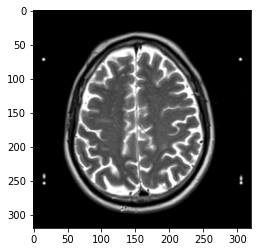

In [0]:
plt.imshow(init_imgs[0], cmap = 'gray')

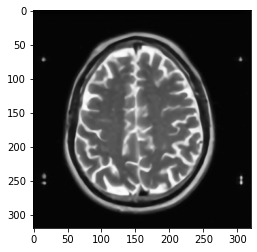

In [0]:
plt.imshow(imgs_4[0], cmap = 'gray')

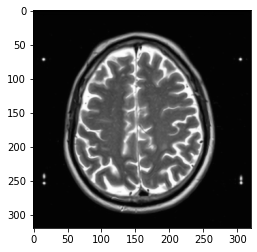

In [0]:
plt.imshow(imgs_2[0], cmap = 'gray')

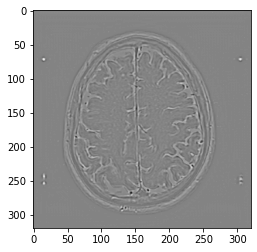

In [0]:
plt.imshow(imgs_4_diff[0], cmap = 'gray')

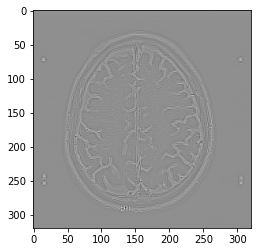

In [0]:
plt.imshow(imgs_2_diff[0], cmap = 'gray')

In [0]:
images[0][:-4]

'103330685055_1.'

In [0]:
.astype(np.uint8)

In [0]:
imgs_2[0]

array([[ 2.0330993e-03,  4.0584858e-04, -4.5333132e-03, ...,
         8.6843539e-03,  7.2531449e-03,  9.2818514e-03],
       [-9.0136994e-03, -6.7591830e-03, -4.9339300e-03, ...,
        -1.0615170e-02, -1.1278896e-02, -5.7106502e-03],
       [ 4.5461422e-03, -1.8900889e-03, -2.9896933e-03, ...,
        -1.9347377e-03, -8.0988854e-03,  1.2305417e-03],
       ...,
       [-4.1644913e-03,  2.5037068e-03,  1.4389288e-03, ...,
         3.4687659e-04, -4.4309571e-05, -2.3734148e-03],
       [-5.2966317e-04,  3.7042394e-03,  5.0304108e-04, ...,
         3.6257127e-04,  1.9469156e-03,  3.3248400e-03],
       [-2.8623894e-03,  4.3500206e-03,  1.2042370e-03, ...,
         3.8034522e-03,  3.1799693e-03,  7.4183927e-03]], dtype=float32)

In [0]:
from PIL import Image

In [0]:
im = Image.fromarray(imgs_2[0]*255.0).convert('RGB')

In [0]:
im.save("a.png")

In [0]:
for i in range(5):
    im1, im2, im3, im4, im5 = Image.fromarray(init_imgs[i]*255.0).convert('RGB'), \ 
                                              Image.fromarray(imgs_2[i]*255.0).convert('RGB'), \
                                              Image.fromarray(imgs_2_diff[i]*255.0).convert('RGB'), \
                                              Image.fromarray(imgs_4[i]*255.0).convert('RGB'), \
                                              Image.fromarray(imgs_4_diff[i]*255.0).convert('RGB')
    im_name = '/content/drive/My Drive/data/dl-bia/' + images[i][:-4]
    im1.save(im_name + ".png")
    im2.save(im_name + "_х2.png")
    im3.save(im_name + "_х2_diff.png")
    im4.save(im_name + "_х4.png")
    im5.save(im_name + "_х4_diff.png")